# Mapping road density and connectivity

Using Overture, we calculate road density for each OSMLR class

We will also attempt to calculate connectivity, based on Ewing, 1996

In [35]:
import sys, os, io, multiprocessing
import urllib3
import boto3
import rasterio
import overturemaps

import geopandas as gpd
import pandas as pd
import GOSTrocks.rasterMisc as rMisc

from GOSTrocks.misc import tPrint
from shapely.geometry import shape, box
from urllib3.exceptions import InsecureRequestWarning
from tqdm.notebook import tqdm
from botocore import UNSIGNED
from botocore.config import Config
from pystac_client import Client


sys.path.append("../../src")
import global_zonal
import h3_helper

sys.path.append(r"C:\WBG\Work\Code\GOSTnetsraster\src")
import GOSTnetsraster.market_access as ma
import GOSTnetsraster.conversion_tables as speed_tables

AWS_S3_BUCKET = "wbg-geography01"
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_SESSION_TOKEN = os.getenv("AWS_SESSION_TOKEN")
# Suppress InsecureRequestWarning
urllib3.disable_warnings(InsecureRequestWarning)

s3_client = boto3.client('s3', verify=False)


In [14]:
base_folder = r"C:\WBG\Work\S2S"
data_folder = os.path.join(base_folder, "data", "roads")
m_crs = 'ESRI:54032'

h3_level = 6

h3_1_list = h3_helper.generate_lvl1_lists(h3_level, return_gdf=True, buffer0=False, pickle_file="h1_dictionary_of_h6_geodata_frames_land.pickle")
    

Loading pickle file h1_dictionary_of_h6_geodata_frames_land.pickle: it exists True


In [ ]:
h3_id = '817a7ffffffffff'
h3_gdf = h3_1_list[h3_id]

bbox = h3_gdf.total_bounds.tolist()  # minx, miny, maxx, maxy
transport = overturemaps.record_batch_reader("segment", bbox).read_all()
transport_df = gpd.GeoDataFrame.from_arrow(transport)
transport_df.crs = 4326

In [30]:
# Map OSMLR classes
transport_df['OSMLR_class'] = transport_df['class'].map(speed_tables.OSMLR_Classes)
transport_df['OSMLR_class'] = transport_df['OSMLR_class'].fillna('Other')
if transport_df.crs != m_crs:
    transport_df = transport_df.to_crs(m_crs)

In [43]:
if h3_gdf.crs != transport_df.crs:
    h3_gdf = h3_gdf.to_crs(transport_df.crs)

res = {}
for idx, row in tqdm(h3_gdf.iterrows(), total=h3_gdf.shape[0]):
    sel_roads = gpd.sjoin(transport_df, gpd.GeoDataFrame([row], crs=transport_df.crs), predicate='intersects', how='inner')
    if sel_roads.shape[0] > 3:
        break
        sel_roads['geometry'] = sel_roads.geometry.intersection(row.geometry)
        sel_roads['length_m'] = sel_roads.geometry.length
        res[row['shape_id']] = sel_roads.groupby('OSMLR_class')['length_m'].sum()


  0%|          | 0/16807 [00:00<?, ?it/s]

In [63]:
xx = sel_roads.union_all()
for y in xx.geoms:
    y.intersection(xx)

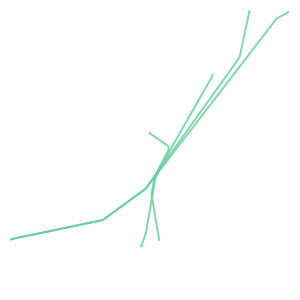

In [67]:
xx

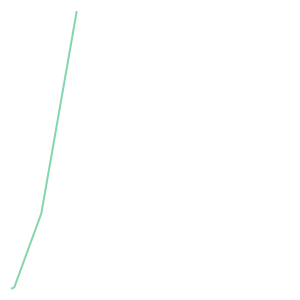

In [65]:
y